In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [2]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
data = pd.read_csv('Obfuscated-MalMem2022-v3.csv')
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
data['class']=lab.fit_transform(data['Class'])
#data['category']=lab.fit_transform(data['Category'])
#data['family']=lab.fit_transform(data['Family'])
data = data.drop(['Class'], axis=1)
data = data.drop(['Category'], axis=1)
data = data.drop(['Family'], axis=1)
#columns with 0 values
data = data.drop(['pslist.nprocs64bit'], axis=1)
data = data.drop(['handles.nport'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool_false_avg'], axis=1)
data = data.drop(['svcscan.interactive_process_services'], axis=1)
data = data.drop(['callbacks.nanonymous'], axis=1)
data = data.drop(['modules.nmodules'], axis=1)
data = data.drop(['callbacks.ngeneric'], axis=1)
data = data.drop(['svcscan.fs_drivers'], axis=1)

In [3]:
data = data.drop_duplicates()

<h3>Normalization</h3>

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = data.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [5]:
# Split the dataset into features (X) and labels (y)
X = data.drop(columns=["class"]).values
y = data["class"].values
X.shape

(58027, 46)

In [6]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode the target labels
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y_encoded)
X_smote.shape

(58462, 46)

<h3>Bi-LSTM with 20 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 20/20 [06:05<00:00, 18.30s/it]


Mean Accuracy Across Folds: 99.99%
Mean Training Loss: 0.0005


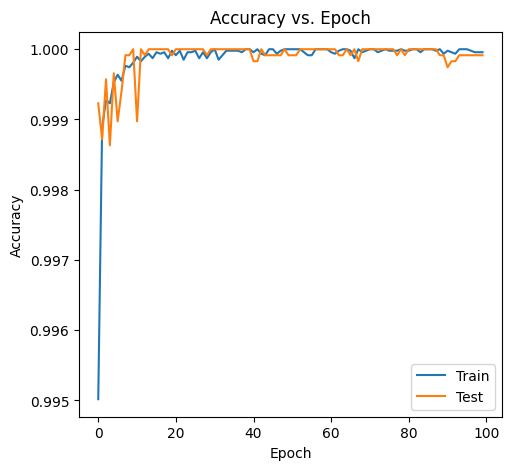

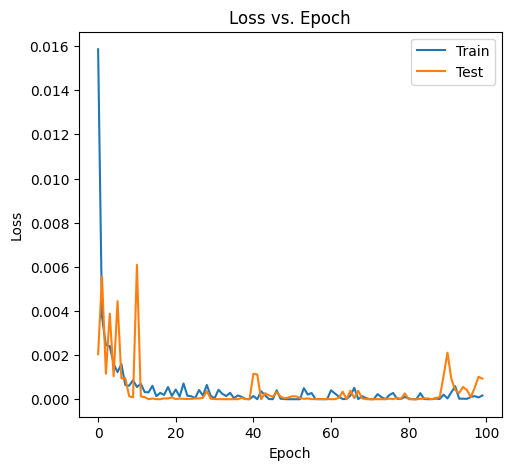

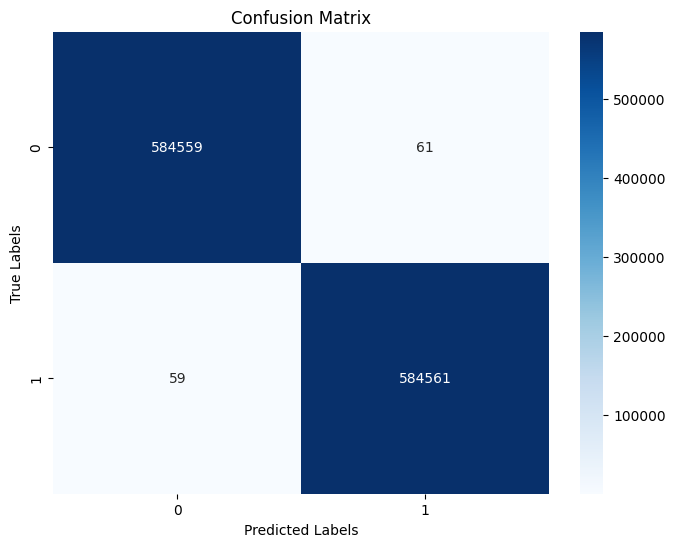

Mean Training Time (per epoch): 18.02 seconds
Mean Testing Time (per epoch): 1.23 seconds


In [8]:
# Define your dataset and labels (X and y) here
X = X_smote
y = y_smote

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define a Bi-LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 46  # Number of input features
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
num_classes = 2  # Number of classes

# Create an instance of the Bi-LSTM model
model = BiLSTM(input_size, hidden_size, num_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop
num_epochs = 20  # Specify the number of training epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Initialize a variable to store the total training loss
total_training_loss = 0.0
total_batches = 0

for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            total_batches += 1

        # Accumulate the training loss for this batch
        total_training_loss += running_train_loss

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        start_time = time.time()  # Start timing the testing phase

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Print and visualize results (training and test accuracy, loss)
print(f"Mean Accuracy Across Folds: {np.mean(fold_accuracies) * 100:.2f}%")
# Calculate the mean training loss
mean_training_loss = total_training_loss / total_batches

# Print the mean training loss
print(f'Mean Training Loss: {mean_training_loss:.4f}')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train")
plt.plot(range(len(test_accuracies)), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/20_ep_accuracy.pdf', format='pdf')
plt.show()

plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(len(test_losses)), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/20_ep_loss.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and display the confusion matrix for the last fold
model.eval()
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/20_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and print the mean training and testing times
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

<h3>Bi-LSTM with 30 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 30/30 [09:08<00:00, 18.30s/it]


Mean Accuracy Across Folds: 99.99%
Mean Training Loss: 0.0003


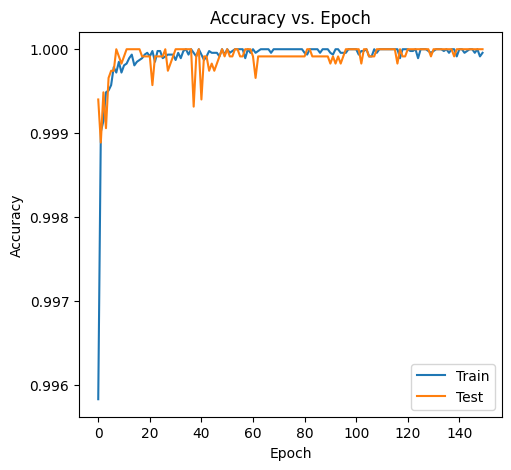

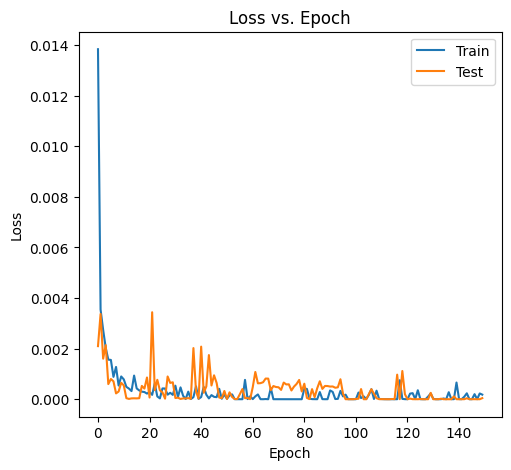

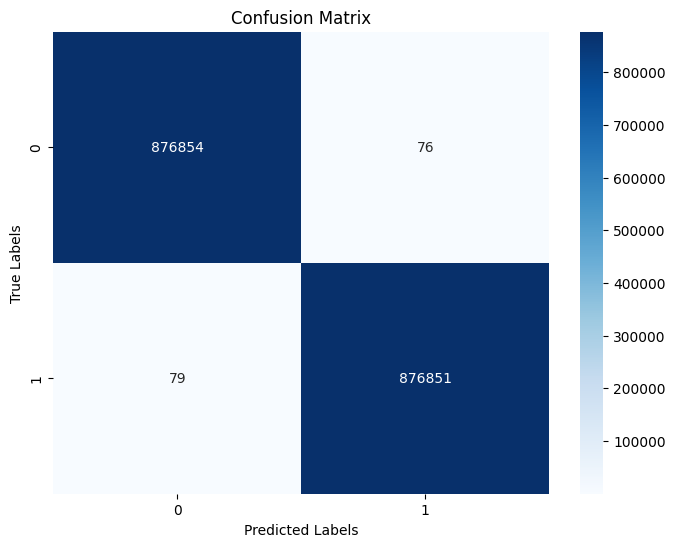

Mean Training Time (per epoch): 18.17 seconds
Mean Testing Time (per epoch): 1.22 seconds


In [9]:
# Define your dataset and labels (X and y) here
X = X_smote
y = y_smote

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define a Bi-LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 46  # Number of input features
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
num_classes = 2  # Number of classes

# Create an instance of the Bi-LSTM model
model = BiLSTM(input_size, hidden_size, num_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop
num_epochs = 30  # Specify the number of training epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Initialize a variable to store the total training loss
total_training_loss = 0.0
total_batches = 0

for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            total_batches += 1

        # Accumulate the training loss for this batch
        total_training_loss += running_train_loss

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        start_time = time.time()  # Start timing the testing phase

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Print and visualize results (training and test accuracy, loss)
print(f"Mean Accuracy Across Folds: {np.mean(fold_accuracies) * 100:.2f}%")
# Calculate the mean training loss
mean_training_loss = total_training_loss / total_batches

# Print the mean training loss
print(f'Mean Training Loss: {mean_training_loss:.4f}')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train")
plt.plot(range(len(test_accuracies)), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/30_ep_accuracy.pdf', format='pdf')
plt.show()

plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(len(test_losses)), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/30_ep_loss.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and display the confusion matrix for the last fold
model.eval()
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/30_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and print the mean training and testing times
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

<h3>Bi-LSTM with 50 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 50/50 [16:03<00:00, 19.27s/it]


Mean Accuracy Across Folds: 100.00%
Mean Training Loss: 0.0002


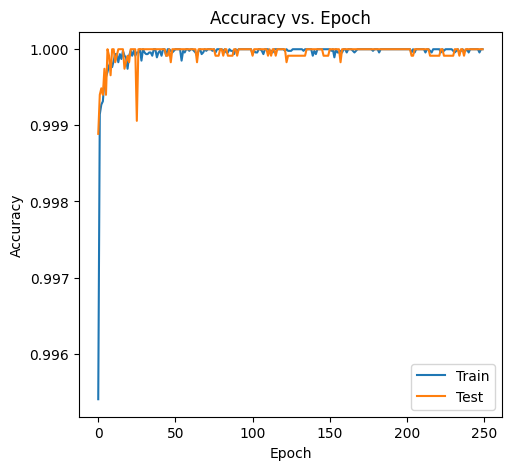

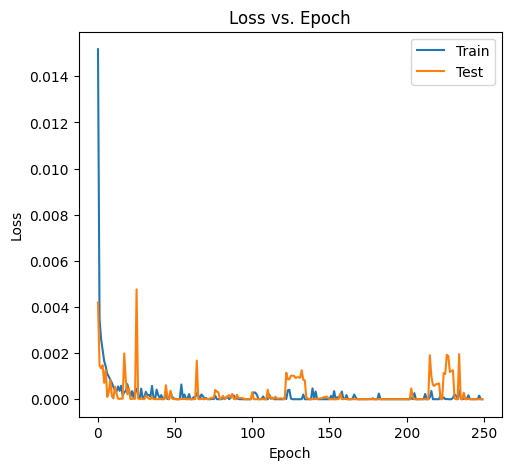

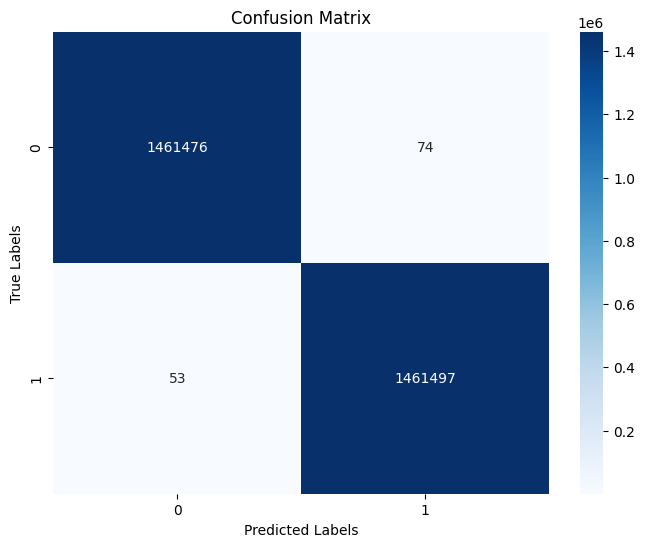

Mean Training Time (per epoch): 18.78 seconds
Mean Testing Time (per epoch): 1.22 seconds


In [10]:
# Define your dataset and labels (X and y) here
X = X_smote
y = y_smote

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define a Bi-LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 46  # Number of input features
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
num_classes = 2  # Number of classes

# Create an instance of the Bi-LSTM model
model = BiLSTM(input_size, hidden_size, num_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop
num_epochs = 50  # Specify the number of training epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Initialize a variable to store the total training loss
total_training_loss = 0.0
total_batches = 0

for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            total_batches += 1

        # Accumulate the training loss for this batch
        total_training_loss += running_train_loss

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        start_time = time.time()  # Start timing the testing phase

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Print and visualize results (training and test accuracy, loss)
print(f"Mean Accuracy Across Folds: {np.mean(fold_accuracies) * 100:.2f}%")
# Calculate the mean training loss
mean_training_loss = total_training_loss / total_batches

# Print the mean training loss
print(f'Mean Training Loss: {mean_training_loss:.4f}')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train")
plt.plot(range(len(test_accuracies)), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/50_ep_accuracy.pdf', format='pdf')
plt.show()

plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(len(test_losses)), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/50_ep_loss.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and display the confusion matrix for the last fold
model.eval()
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/50_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and print the mean training and testing times
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

<h3>Bi-LSTM with 100 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 100/100 [29:59<00:00, 18.00s/it]


Mean Accuracy Across Folds: 100.00%
Mean Training Loss: 0.0001


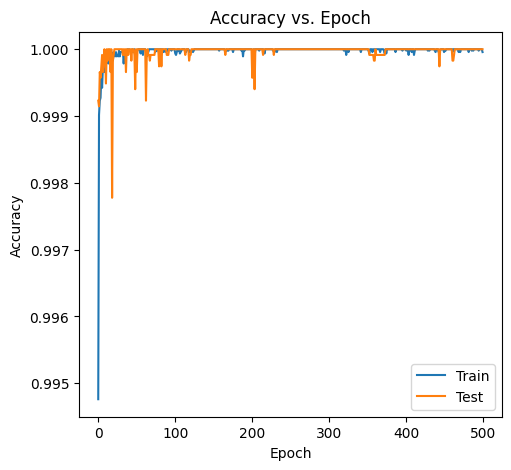

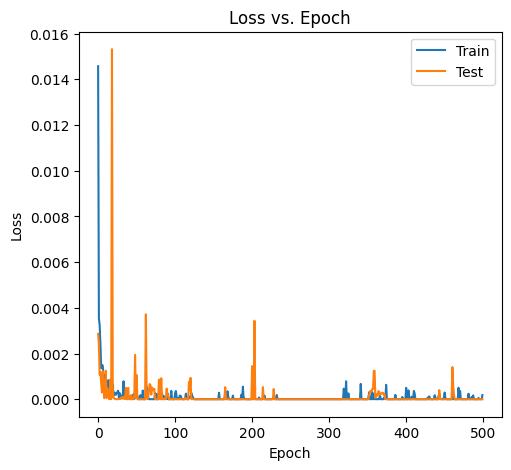

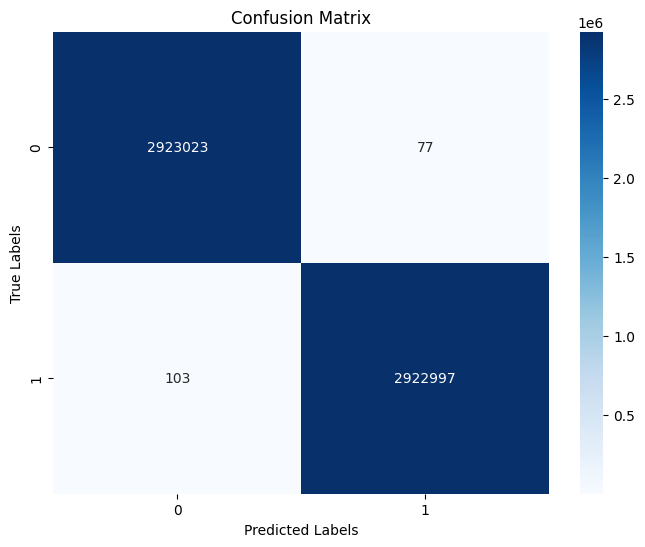

Mean Training Time (per epoch): 20.05 seconds
Mean Testing Time (per epoch): 1.17 seconds


In [11]:
# Define your dataset and labels (X and y) here
X = X_smote
y = y_smote

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define a Bi-LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 46  # Number of input features
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
num_classes = 2  # Number of classes

# Create an instance of the Bi-LSTM model
model = BiLSTM(input_size, hidden_size, num_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop
num_epochs = 100  # Specify the number of training epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Initialize a variable to store the total training loss
total_training_loss = 0.0
total_batches = 0

for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            total_batches += 1

        # Accumulate the training loss for this batch
        total_training_loss += running_train_loss

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        start_time = time.time()  # Start timing the testing phase

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Print and visualize results (training and test accuracy, loss)
print(f"Mean Accuracy Across Folds: {np.mean(fold_accuracies) * 100:.2f}%")
# Calculate the mean training loss
mean_training_loss = total_training_loss / total_batches

# Print the mean training loss
print(f'Mean Training Loss: {mean_training_loss:.4f}')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train")
plt.plot(range(len(test_accuracies)), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/100_ep_accuracy.pdf', format='pdf')
plt.show()

plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(len(test_losses)), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/100_ep_loss.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and display the confusion matrix for the last fold
model.eval()
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/bi-lstm/100_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and print the mean training and testing times
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

<h3>Bi-LSTM with 150 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 150/150 [1:17:50<00:00, 31.14s/it]


Mean Accuracy Across Folds: 100.00%
Mean Training Loss: 0.0001


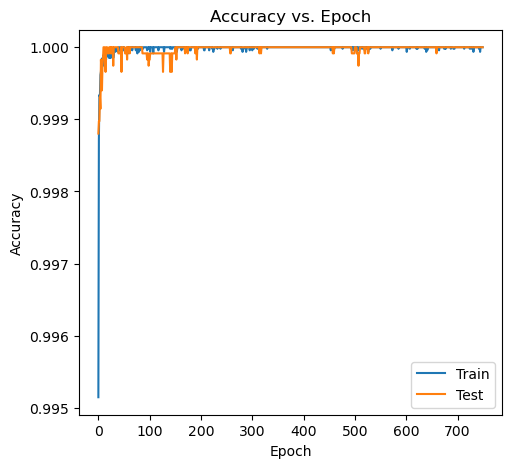

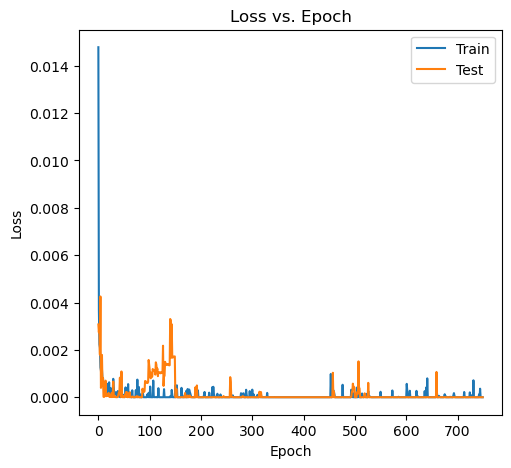

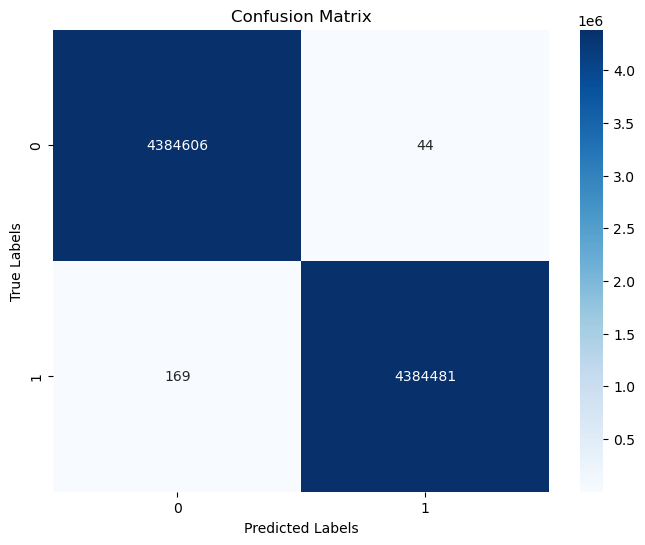

Mean Training Time (per epoch): 33.12 seconds
Mean Testing Time (per epoch): 1.51 seconds


In [7]:
# Define your dataset and labels (X and y) here
X = X_smote
y = y_smote

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Define a Bi-LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(lstm_out)
        return output

# Specify the model hyperparameters
input_size = 46  # Number of input features
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
num_classes = 2  # Number of classes

# Create an instance of the Bi-LSTM model
model = BiLSTM(input_size, hidden_size, num_layers, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Initialize a variable to store the total training loss
total_training_loss = 0.0
total_batches = 0

for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            total_batches += 1

        # Accumulate the training loss for this batch
        total_training_loss += running_train_loss

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        start_time = time.time()  # Start timing the testing phase

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

    # Store accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Print and visualize results (training and test accuracy, loss)
print(f"Mean Accuracy Across Folds: {np.mean(fold_accuracies) * 100:.2f}%")
# Calculate the mean training loss
mean_training_loss = total_training_loss / total_batches

# Print the mean training loss
print(f'Mean Training Loss: {mean_training_loss:.4f}')
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train")
plt.plot(range(len(test_accuracies)), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('C:/Users/hp/Thesis/malmem2022/DL_Models/Detection/graphs/bilstm/150_ep_accuracy.pdf', format='pdf')
plt.show()

plt.close()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(len(test_losses)), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('C:/Users/hp/Thesis/malmem2022/DL_Models/Detection/graphs/bilstm/150_ep_loss.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and display the confusion matrix for the last fold
model.eval()
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/hp/Thesis/malmem2022/DL_Models/Detection/graphs/bilstm/150_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

# Calculate and print the mean training and testing times
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')